# PC Lab 7: Tree-based Methods
---

Decision trees are very popular in machine learning. They contain a number of favourable properties, amongst which:
- Interpretability,
- Visualization,
- Able to handle missing values and 'mixed' data (e.g. a dataset consisting of a mix of categorical and continuous features),
- Able to deal with non-linearity,
- No need to normalize the data,
- Naturally extendable to a multi-class setting.

When many randomized decision trees are bagged in a single model, we obtain the powerful _Random Forest_ classifier (check out [this paper](http://jmlr.org/papers/volume15/delgado14a/delgado14a.pdf), where 179 classifiers from 17 families have been evaluated on 121 datasets). The Random Forest classifier is among the most popular machine learning methods available due to its high performance on most problems, not needing much or any tuning and the possibility of providing variable importance insights. The training of a random forest model can easily be done in parallel (e.g. fitting multiple trees on separate CPUs), making it a suitable method for large-scale data applications. Furthermore, it inherits the favourable properties of decision trees listed above.

In this PC lab, we will use the [Breast Cancer Wisconsin (Diagnostic) Data Set](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic)). Run the following codeblock to download the dataset.

In [1]:
!wget https://raw.githubusercontent.com/tfmortie/mlmust/main/07_trees/wdbc.data

--2024-01-26 15:41:18--  https://raw.githubusercontent.com/tfmortie/mlmust/07_trees/wdbc.data
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-01-26 15:41:18 ERROR 404: Not Found.



## 1. Decision trees

When a decision tree is fitted to the data, the feature space is recursively splitted. Decision trees make use of a purity measure in order to choose a feature to make a split. Such a purity measure assesses the homogeneity of the labels within the leaf of a decision tree. You have seen two such measures during the theory lecture, the entropy and gini-index measures. In a $K$-class classification setting, having class labels $1, ..., K$, the purity of a set of instances $\{(x_1,y_1), ..., (x_n,y_n)\}$ in a leaf can be defined using the proportions $p_1, ..., p_K$ (where $I$ is defined as the identity-function):

$$p_k = \frac{\sum_{i=1}^{n}I(y_i = k)}{n}, \qquad k = 1, ..., K,$$

$$\text{entropy} = -\sum_{k=1}^{K}p_k \ln{p_k}, \qquad \text{gini-index} = \sum_{k=1}^{K} p_k(1-p_k).$$

These purity measures can be used to split the feature space until a certain leaf is pure. Decision trees are called a _greedy_ approach, as they will choose that feature which will result in the greatest drop for a purity measure at a certain split, not taking the effect of future splits into account.  

To start of, let's investigate whether the decision tree can handle the XOR problem, a classic toy dataset for which a model needs to be able to handle non-linearities. For this we will use a helper function:

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

''' Function to plot the decision boundary '''
''' X_train: Training dataset to visualize. Needs to be a numpy array of two dimensions.
The first two components are visualized '''
''' clf: Fitted classifier (also to two dimensions) '''

def plot_decision_boundary(X_train, y_train, clf):
    plot_step = 0.02
    x1_min, x1_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    x2_min, x2_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    x1, x2 = np.meshgrid(np.arange(x1_min, x1_max, plot_step),np.arange(x2_min, x2_max, plot_step))
    Z = clf.predict(np.c_[x1.ravel(), x2.ravel()])
    Z = Z.reshape(x1.shape)

    blues = y_train == 0
    reds = y_train == 1

    fig, ax = plt.subplots()
    ax.contourf(x1, x2, Z, cmap=plt.cm.Paired)
    ax.scatter(X_train[reds,0],X_train[reds,1], c='red');
    ax.scatter(X_train[blues,0],X_train[blues,1], c='blue');
    ax.set_xlabel(r'$x_1$', size=18)
    ax.set_ylabel(r'$x_2$', size=18)
    plt.show()

Generate the dataset:

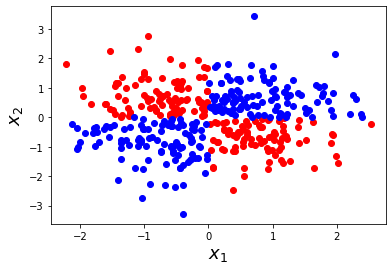

In [3]:
X_train = np.random.randn(400, 2)
y_train = np.logical_xor(X_train[:, 0] > 0, X_train[:, 1] > 0)

blues = y_train == 0
reds = y_train == 1

fig, ax = plt.subplots()
ax.scatter(X_train[reds,0],X_train[reds,1], c='red');
ax.scatter(X_train[blues,0],X_train[blues,1], c='blue');
ax.set_xlabel(r'$x_1$', size=18)
ax.set_ylabel(r'$x_2$', size=18)
plt.show()

We can fit decision trees using the already-familiar sklearn interface ([link to docs](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)).

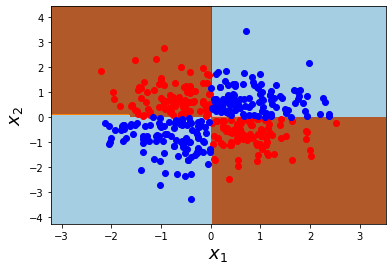

In [4]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, clf)

<div class="alert alert-success">
<b>WARM-UP EXERCISE:
<br>
Think about some other classifiers we have already discussed during this course. How will they square up against the XOR problem? What kind of decision boundary do you expect in the case of e.g. logistic regression? Try plugging some classifiers into the code above and test if the results confirm your intuition.
</b>
</div>

Let's apply a decision tree on a practical dataset. For this we will load the previously-mentioned wisconsin breast cancer dataset:

In [5]:
data = pd.read_csv(
    './wdbc.data',
    index_col=0)
status = data['status']
display(data.head(5))
print('Number of benign cases: ' + str(data[data.loc[:,'status']=='B'].shape[0]))
print('Total number of cases: ' + str(data.shape[0]))

,status,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Number of benign cases: 357
Total number of cases: 569


<div class="alert alert-success">

<b>EXERCISE 1.1</b>: **Fit a decision tree classifier that predicts whether a tumor is malign or bening. Evaluate the classifier on both the training and test set. Investigate the [Scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) in order to tune your model appropriately.**
</div>

In [6]:
## ALTERNATIVE ANSWER USING HYPERPARAMETER TUNING ##
from sklearn.model_selection import train_test_split, GridSearchCV

y = (data['status'] == "M").values.astype(int)
X = data.drop('status', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

dt = DecisionTreeClassifier()

parameter_grid = {
    "max_depth": [2, 3, 4, 5],
    "criterion": ["gini", "entropy"],
    "class_weight": [None, "balanced"]
    }

clf = GridSearchCV(dt, parameter_grid)
clf.fit(X_train,y_train)
acc_train = clf.score(X_train,y_train)
acc_test = clf.score(X_test,y_test)

print("Best hyperparameters: " + str(clf.best_params_))
print('Accuracy tuned decision tree on training set: ' + str(acc_train))
print('Accuracy tuned decision tree on test set: ' + str(acc_test))

Best hyperparameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 4}
Accuracy tuned decision tree on training set: 0.9921259842519685
Accuracy tuned decision tree on test set: 0.9521276595744681


## 2. Random Forests

Random Forests are a very popular method used in various fields, ranging from bioinformatics to data competitions (have a look at [this introduction](http://onlinelibrary.wiley.com/doi/10.1002/widm.1072/abstract)  for computational biologists and bioinformaticians). This is because they are known for their high performance, yet they are easy to implement. Random Forests make use of two kinds of randomization:
- The method aggregates the result of individual unpruned trees, grown on bootstrap (sub)samples of the dataset; this is called _bagging_ (**b**ootstrap **agg**regat**ing**).
- Whenever a decision tree makes a split, only a random subset of the present features are offered to the decision tree.

Random Forests are part of a larger class of models which are called _ensemble models_. The power of ensemble methods can be attributed to some kind of ["wisdom of the crowd"](https://en.wikipedia.org/wiki/Wisdom_of_the_crowd) phenomenon: averaging the results of many "simple" models is often better than relying on one "advanced" model, just as the collective judgement of a large group of "average" persons may be more reliable than that from one "expert". For random forests, the two kinds of randomization (+ optionally other kinds of regularization) aid in making the individual trees "simple".

After model fitting, for classification, a majority vote of all trees is taken to make a prediction for a new sample. For regression problems, the average prediction across trees is calculated.

The [Scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) of Random Rorests works similarly to that of decision trees, albeit with some differences in terms of the hyperparameters. The two most important hyperparameters are the number of trees that is grown and the number of subsetted features that is offered when making a split. **Important: the default values of these parameters usually lead to a good performance, however, model selection is of course recommended.**

<div class="alert alert-success">

<b>EXERCISE 2.1</b>: **Repeat the previous exercise, however, this time by using the [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) class in Scikit-learn. Use the same data split as in the previous exercise and compare your results. Investigate what features are important for the downtask at hand (hint: have a look at the attributes of the class in the provided documentation).** 
</div>

In [7]:
## ALTERNATIVE ANSWER USING HYPERPARAMETER TUNING + EVALUATING MODEL USING RECALL ##
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

y = (data['status'] == "M").values.astype(int)
X = data.drop('status', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

rf = RandomForestClassifier()

parameter_grid = {
    "max_depth": [2, 3],
    "n_estimators": [10, 50, 100],
    "max_features": [0.5, 0.75],
    "max_samples": [0.5, 0.75]
    }

clf = GridSearchCV(rf, parameter_grid, scoring = "recall")
clf.fit(X_train,y_train)

# Remember that .score() will use the function provided by the scoring="" argument, so in this case, recall
recall_train = clf.score(X_train,y_train)
recall_test = clf.score(X_test,y_test)

print("Best hyperparameters: " + str(clf.best_params_))
print('Recall tuned random forest on training set: ' + str(recall_train))
print('Recall tuned random forest on test set: ' + str(recall_test))

Best hyperparameters: {'max_depth': 2, 'max_features': 0.75, 'max_samples': 0.5, 'n_estimators': 50}
Recall tuned random forest on training set: 0.9375
Recall tuned random forest on test set: 0.9264705882352942


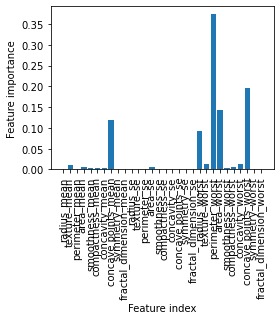

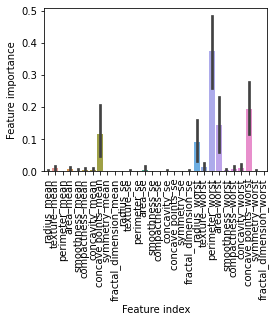

In [8]:
# simple plot using the feature importance attribute in the RF object:
plt.figure(figsize=(4,3))
plt.bar(
    x = np.arange(X.shape[1]),
    height = clf.best_estimator_.feature_importances_
    )
plt.ylabel('Feature importance')
plt.xlabel('Feature index')
plt.xticks(ticks = np.arange(X.shape[1]), labels = data.columns[1:], rotation = 90)

# More elaborate using the features importances of all the trees in the RF object to get error bars:
import seaborn as sns

importances = np.array([tree.feature_importances_ for tree in clf.best_estimator_.estimators_])
indices = np.array([np.arange(importances.shape[1]) for _ in range(importances.shape[0])])
data_to_plot = pd.DataFrame([indices.reshape(-1), importances.reshape(-1)]).T
data_to_plot[0] = data_to_plot[0].astype(int)
plt.figure(figsize=(4,3))
sns.barplot(data = data_to_plot, x=0, y=1)
plt.ylabel('Feature importance')
plt.xlabel('Feature index')
plt.xticks(ticks = np.arange(X.shape[1]), labels = data.columns[1:], rotation = 90)
plt.show()

## 3. OPTIONAL: XGBoost

Boosting is a subclass of ensembling in which (similarly) many simpler models team up to create a performant model. The difference is that in boosting, subsequent trees try to correct the mistakes of the previous one(s). The most famous example, XGBoost or eXtreme Gradient Boosting is a decision-tree-based algorithm that uses a gradient boosting framework. The algorithm was developed by Tianqi Chen and Carlos Guestrin and more details can be found [here](https://arxiv.org/pdf/1603.02754.pdf). The technique has managed to win numerous kaggle competitions and is currently tied to an active open source [project](https://github.com/dmlc/xgboost/).

**Informally, performant boosting implementations such as XGBoost, [CatBoost](https://catboost.ai/) and [LightGBM](https://lightgbm.readthedocs.io/en/v3.3.2/), have been crowned as kings of machine learning on tabular, structured datasets. In contrast, for unstructured data such as language, vision or audio, neural networks – which will be the topic of the last two practicals -- have been informally crowned as kings of "perceptual".**

Some of the main characteristics that make XGboost an appealing choice include:
- Can be used to solve different type of prediction problems (regression, classification, ranking)
- Runs on every popular OS (Windows, Linux, and OS X)
- Supports all major programming languages (C++, Python, R, Java, Scala, and Julia)


The library we are going to use is quite flexible as it supports the following cases:

- Trees are constructed in parallel using all of available CPU cores during training.
- Very large models can use a cluster of machines in a distributed fashion.
- Very large datasets that don’t fit into memory are handled with out-of-Core Computing.

There is no additional exercise linked to XGBoost. It suffices to say that the XGBoost Python package can be installed with the cell below and that the package uses a similar API as in Scikit-learn: `.fit()`, `.predict()`, ... More information about the packages can be found here: [XGBRegressor](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor) and [XGBClassifier](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier). We invite you to play around with the model by plugging XGBoost in the above exercise.

In [9]:
!pip install xgboost

     |████████████████████████████████| 2.2 MB 6.4 MB/s eta 0:00:01
